Fitting 3 folds for each of 20 candidates, totalling 60 fits

=== RandomizedSearchCV completed ===
Best params: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 10}
Best CV balanced accuracy: 0.4019347495703572
              precision    recall  f1-score   support

        High       0.58      0.56      0.57        75
         Low       0.32      0.25      0.28        28
      Medium       0.49      0.63      0.55        78
 Medium High       0.30      0.22      0.25        46

    accuracy                           0.48       227
   macro avg       0.42      0.41      0.41       227
weighted avg       0.46      0.48      0.46       227

Balanced Accuracy: 0.4138991081382386
F1 Macro: 0.41378873153585144


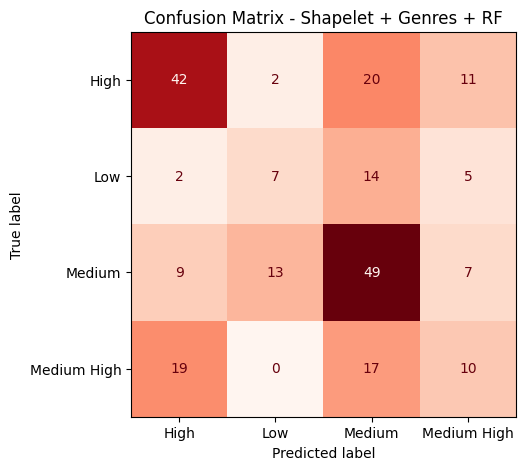

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sktime.transformations.panel.shapelet_transform import RandomShapeletTransform
from sktime.datatypes._panel._convert import from_2d_array_to_nested
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
import os


# --- Caricamento dataset ---
# df = pd.read_csv("/Users/chiaraferrara/Desktop/Unipi/Magistrale/DM 2/dm2_project/dm2_dataset_2425_imdb/imdb_ts.csv")

# get parent dir
parent_dir = os.path.dirname(os.getcwd())

# load the dataset
df = pd.read_csv(os.path.join(
    parent_dir, 'dm2_dataset_2425_imdb',
    'imdb_ts.csv'))



# --- Preprocessing genre ---
df['genre'] = df['genre'].apply(lambda x: x.split(',') if pd.notna(x) else x)
# clean genre column from [, ], '
df['genre'] = df['genre'].apply(
    lambda x: [i.strip().replace("'", "").replace("[", "").replace("]", "") for i in x] if isinstance(x, list) else x
)

# Compute frequency encoding for each genre
from collections import Counter
genre_counts = Counter(genre for sublist in df['genre'].dropna() for genre in sublist)
genre_freq = {genre: count / len(df) for genre, count in genre_counts.items()}

# convert genre column into genre1, genre2, genre3 columns, sorting on frequency
df['genre'] = df['genre'].apply(lambda x: sorted(x, key=lambda y: genre_freq.get(y, 0), reverse=True) if isinstance(x, list) else x)

genre_cols = ['genre1', 'genre2', 'genre3']

df[genre_cols] = pd.DataFrame(df['genre'].tolist(), index=df.index).iloc[:, :3]
df = df.drop(columns=['genre'])

# convert genre columns into frequency encoding
df['genre1'] = df['genre1'].map(genre_freq)
df['genre2'] = df['genre2'].map(genre_freq)
df['genre3'] = df['genre3'].map(genre_freq)

df = df.fillna(0)

#sto aggiungendo qui!
X_genres = df[genre_cols].fillna(0).values





# Merge classi poco rappresentate
df["rating_category"] = df["rating_category"].replace({"Medium Low": "Low"})

# Feature e target
X_ts = df.iloc[:, 1:100].values
y = df["rating_category"].values

# Encoding target
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# --- Split dati ---
# X_train, X_test, y_train, y_test = train_test_split(
#     X_ts, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
# )
X_train_ts, X_test_ts, X_train_genre, X_test_genre, y_train, y_test = train_test_split(
    X_ts, X_genres, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# --- Log-transform + Normalizzazione ---
X_train_log = np.log1p(X_train_ts)
X_test_log = np.log1p(X_test_ts)

scaler_ts = TimeSeriesScalerMeanVariance()
X_train_scaled = scaler_ts.fit_transform(X_train_log)
X_test_scaled = scaler_ts.transform(X_test_log)

# Conversione in formato nested per sktime
X_train_nested = from_2d_array_to_nested(X_train_scaled.squeeze())
X_test_nested = from_2d_array_to_nested(X_test_scaled.squeeze())

# ==========================
# Shapelet Transform + RandomizedSearchCV su RandomForest
# ==========================
shapelet_transform = RandomShapeletTransform(
    max_shapelets=200,
    min_shapelet_length=3,
    max_shapelet_length=30,
    random_state=42,
    n_jobs=-1
)


shapelet_transform.fit(X_train_nested, y_train)

X_train_shapelets = shapelet_transform.transform(X_train_nested)
X_test_shapelets = shapelet_transform.transform(X_test_nested)

X_train_combined = np.hstack([X_train_shapelets, X_train_genre])
X_test_combined = np.hstack([X_test_shapelets, X_test_genre])

# Scaling finale
scaler_final = StandardScaler()
X_train_final = scaler_final.fit_transform(X_train_combined)
X_test_final = scaler_final.transform(X_test_combined)

#### CLASS WEIGHT BALANCED ####
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
#shapelet_pipeline = make_pipeline(shapelet_transform, rf_clf)

# # Parametri da ottimizzare per la Random Forest all'interno della pipeline
# param_dist = {
#     "randomforestclassifier__n_estimators": [100, 200, 300],
#     "randomforestclassifier__max_depth": [None, 10, 20, 30],
#     "randomforestclassifier__min_samples_split": [2, 5, 10],
#     "randomforestclassifier__min_samples_leaf": [1, 2, 4],
# }


param_dist = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", None]
}

random_search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=20,           
    cv=3,
    scoring="balanced_accuracy",   
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# random_search = RandomizedSearchCV(
#     shapelet_pipeline,
#     param_distributions=param_dist,
#     n_iter=10,
#     cv=3,
#     scoring="accuracy",
#     n_jobs=-1,
#     random_state=42
# )

# Fit della RandomizedSearch
random_search.fit(X_train_final, y_train)

print("\n=== RandomizedSearchCV completed ===")
print("Best params:", random_search.best_params_)
print("Best CV balanced accuracy:", random_search.best_score_)
# print("=== Shapelet Transform + RF (log-transformed) RandomizedSearchCV ===")
# print("Best params:", random_search.best_params_)
# print("Best CV accuracy:", random_search.best_score_)

# Valutazione sul test set
y_pred = random_search.predict(X_test_final)
# y_pred = random_search.predict(X_test_nested)
# print(classification_report(y_test, y_pred, target_names=le.classes_))

# cm = confusion_matrix(y_test, y_pred, labels=np.arange(len(le.classes_)))
# plt.figure(figsize=(5, 5))
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
# disp.plot(cmap="Reds", colorbar=False, ax=plt.gca())
# plt.xticks(rotation=0, ha='center')
# plt.yticks(rotation=0)
# plt.title("Confusion Matrix - Shapelet RF (log-transformed)")
# plt.show()


print(classification_report(y_test, y_pred, target_names=le.classes_))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
print("F1 Macro:", f1_score(y_test, y_pred, average='macro'))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap="Reds", colorbar=False, ax=plt.gca())
plt.title("Confusion Matrix - Shapelet + Genres + RF")
plt.show()

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sktime.transformations.panel.shapelet_transform import RandomShapeletTransform
from sktime.datatypes._panel._convert import from_2d_array_to_nested
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

# --- Caricamento dataset ---
# df = pd.read_csv("/Users/chiaraferrara/Desktop/Unipi/Magistrale/DM 2/dm2_project/dm2_dataset_2425_imdb/imdb_ts.csv")

# get parent dir
parent_dir = os.path.dirname(os.getcwd())

# load the dataset
df = pd.read_csv(os.path.join(
    parent_dir, 'dm2_dataset_2425_imdb',
    'imdb_ts.csv'))

# Merge classi poco rappresentate
df["rating_category"] = df["rating_category"].replace({"Medium Low": "Low"})

# Feature e target
X_ts = df.iloc[:, 1:100].values
y = df["rating_category"].values

# Encoding target
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# --- Split dati ---
X_train, X_test, y_train, y_test = train_test_split(
    X_ts, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# --- Log-transform + Normalizzazione ---
X_train_log = np.log1p(X_train)
X_test_log = np.log1p(X_test)

scaler_ts = TimeSeriesScalerMeanVariance()
X_train_scaled = scaler_ts.fit_transform(X_train_log)
X_test_scaled = scaler_ts.transform(X_test_log)

# Conversione in formato nested per sktime
X_train_nested = from_2d_array_to_nested(X_train_scaled.squeeze())
X_test_nested = from_2d_array_to_nested(X_test_scaled.squeeze())

# ==========================
# Shapelet Transform + RandomizedSearchCV su RandomForest con class_weight='balanced'
# ==========================
shapelet_transform = RandomShapeletTransform(
    max_shapelets=200,
    min_shapelet_length=3,
    max_shapelet_length=30,
    random_state=42
)

rf_clf = RandomForestClassifier(random_state=42, class_weight='balanced')
shapelet_pipeline = make_pipeline(shapelet_transform, rf_clf)

# Parametri da ottimizzare per la Random Forest all'interno della pipeline
param_dist = {
    "randomforestclassifier__n_estimators": [100, 200, 300],
    "randomforestclassifier__max_depth": [None, 10, 20, 30],
    "randomforestclassifier__min_samples_split": [2, 5, 10],
    "randomforestclassifier__min_samples_leaf": [1, 2, 4],
}

random_search = RandomizedSearchCV(
    shapelet_pipeline,
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    scoring="accuracy",
    n_jobs=-1,
    random_state=42
)

# Fit della RandomizedSearch
random_search.fit(X_train_nested, y_train)

print("=== Shapelet Transform + RF (log-transformed, class_weight='balanced') RandomizedSearchCV ===")
print("Best params:", random_search.best_params_)
print("Best CV accuracy:", random_search.best_score_)

=== Shapelet Transform + RF (log-transformed, class_weight='balanced') RandomizedSearchCV ===
Best params: {'randomforestclassifier__n_estimators': 300, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__max_depth': 30}
Best CV accuracy: 0.4531615413196948


              precision    recall  f1-score   support

         Low       0.75      0.11      0.19        28
      Medium       0.45      0.74      0.56        78
 Medium High       0.29      0.09      0.13        46
        High       0.56      0.59      0.57        75

    accuracy                           0.48       227
   macro avg       0.51      0.38      0.36       227
weighted avg       0.49      0.48      0.43       227



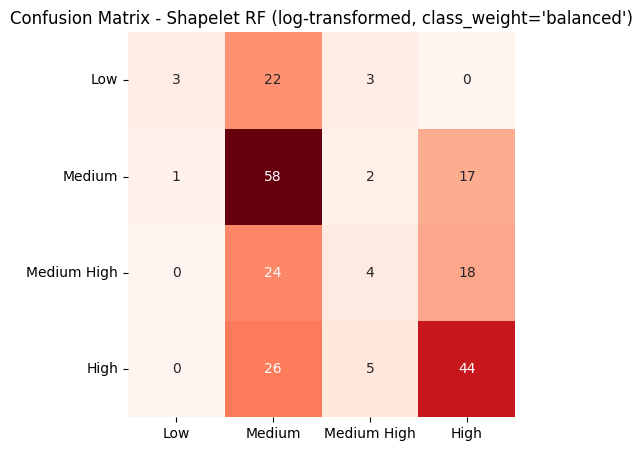

In [16]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Desired order
labels = ['Low', 'Medium', 'Medium High', 'High']

# Map your label encoder classes to numeric values according to the desired order
label_order_indices = [np.where(le.classes_ == lbl)[0][0] for lbl in labels]

# Predictions
y_pred = random_search.predict(X_test_nested)

# Classification report with custom label order
print(classification_report(
    y_test, y_pred, labels=label_order_indices, target_names=labels
))

# Confusion matrix with the same label order
cm = confusion_matrix(y_test, y_pred, labels=label_order_indices)

# Plot
plt.figure(figsize=(5, 5))
sns.heatmap(
    cm, annot=True, fmt='d',
    xticklabels=labels,
    yticklabels=labels,
    cmap='Reds', cbar=False
)
plt.xticks(rotation=0, ha='center')
plt.yticks(rotation=0)
plt.title("Confusion Matrix - Shapelet RF (log-transformed, class_weight='balanced')")
plt.show()


In [18]:
# Print most influential shapelets for each class
st = random_search.best_estimator_.named_steps['randomshapelettransform']
clf = random_search.best_estimator_.named_steps['randomforestclassifier']

# try to get shapelets array and metadata (robust to different attribute names)
shapelets = getattr(st, "shapelets_", None) or getattr(st, "_shapelets", None)
info = getattr(st, "shapelet_info_", None) or getattr(st, "shapelets_info_", None) or getattr(st, "shapelets_infos_", None)

# helper to print a single shapelet entry
def _print_shapelet_entry(idx, shapelet_arr=None, start=None, length=None, quality=None):
    print(f"  - shapelet_idx={idx} start={start} length={length} quality={quality}")
    if shapelet_arr is not None:
        # keep printing compactly
        print("    values:", np.array2string(np.asarray(shapelet_arr), precision=3, separator=", ", max_line_width=120))

if info is not None:
    # normalize info to DataFrame for easier handling
    info_df = info if isinstance(info, pd.DataFrame) else pd.DataFrame(info)
    # detect useful columns
    class_col = next((c for c in ['class_id', 'class', 'y', 'class_labels'] if c in info_df.columns), None)
    id_col = next((c for c in ['shapelet_id', 'id', 'idx', 'index', 'shapelet_index'] if c in info_df.columns), None)
    quality_col = next((c for c in ['quality', 'score', 'gini_gain'] if c in info_df.columns), None)
    start_col = next((c for c in ['start', 'pos'] if c in info_df.columns), None)
    length_col = next((c for c in ['length', 'len'] if c in info_df.columns), None)

    for cid, cls in enumerate(le.classes_):
        # filter by class if available, otherwise show top-general shapelets
        rows = info_df[info_df[class_col] == cid] if class_col is not None else info_df
        if rows.empty:
            print(f"No shapelets found for class '{cls}'")
            continue
        # sort by quality if available
        if quality_col is not None:
            rows = rows.sort_values(by=quality_col, ascending=False)
        print(f"Top shapelets for class '{cls}':")
        for _, r in rows.head(5).iterrows():
            sidx = int(r[id_col]) if id_col is not None and not pd.isna(r[id_col]) else None
            sval = r.get('shapelet', None)
            # prefer shapelet array from metadata, else from shapelets list using sidx
            arr = sval if sval is not None else (shapelets[sidx] if (shapelets is not None and sidx is not None and sidx < len(shapelets)) else None)
            _print_shapelet_entry(sidx, arr, r.get(start_col), r.get(length_col), r.get(quality_col))
        print()
else:
    # fallback: no metadata available -> use RF global feature importances to rank shapelet features
    importances = clf.feature_importances_
    n_show = min(10, len(importances))
    top_idx = np.argsort(importances)[::-1][:n_show]
    print("No shapelet metadata available. Showing top shapelets by RandomForest global feature importance:")
    for rank, fi in enumerate(top_idx, start=1):
        print(f"{rank}. feature_idx={fi} importance={importances[fi]:.6f}")
        if shapelets is not None and fi < len(shapelets):
            _print_shapelet_entry(fi, shapelets[fi])
        else:
            print("   (shapelet values not available)")


No shapelet metadata available. Showing top shapelets by RandomForest global feature importance:
1. feature_idx=176 importance=0.011103
   (shapelet values not available)
2. feature_idx=149 importance=0.009754
   (shapelet values not available)
3. feature_idx=159 importance=0.008929
   (shapelet values not available)
4. feature_idx=175 importance=0.008541
   (shapelet values not available)
5. feature_idx=197 importance=0.008452
   (shapelet values not available)
6. feature_idx=193 importance=0.008404
   (shapelet values not available)
7. feature_idx=125 importance=0.008227
   (shapelet values not available)
8. feature_idx=163 importance=0.008181
   (shapelet values not available)
9. feature_idx=65 importance=0.008063
   (shapelet values not available)
10. feature_idx=186 importance=0.007746
   (shapelet values not available)


In [ ]:
shapelet_git add .transform

RandomShapeletTransform(max_shapelet_length=30, max_shapelets=200,
                        random_state=42)